### Day 5 Notes - Scraping the Web

Doug's code of confidence intervals:

In [1]:
#Confidence interval for age
################

#import
import random
import numpy as np
import scipy as sp
import scipy.stats
import statsmodels.stats.api as sms

#generate data
n =200
ages=[]
for i in range(n):
    ages.append(random.randint(21,65))

#calculate manually
conf = .95
mean = np.mean(ages)

#I couldn't find a sample standard deviation function, so I just transformed it using sqrt(n/(n-1))
sd = np.std(ages)*(n/(n-1))**.5

#Draw a picture of a t distribution to understand the (1+conf)/2 math
tstar = sp.stats.t._ppf((1+conf)/2., n-1)
lower = round(mean - tstar*(sd/n**.5),2)
upper = round(mean + tstar*(sd/n**.5),2)
print('I am 95% confident that the true mean age is between',lower,'and',upper,'years')

#other ways
print(sp.stats.t.interval(0.95, n-1, loc=np.mean(ages), scale=sp.stats.sem(ages)))
print(sms.DescrStatsW(ages).tconfint_mean())


I am 95% confident that the true mean age is between 39.86 and 43.36 years
(39.85540409525821, 43.36459590474179)
(39.85540409525821, 43.36459590474179)


### Example 1: Fantasy football
### Scraping, Cleaning, and Merging Data Off the Web using pd.read_html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

1.) We are interested in how well ESPN does at predicting how well a player will do in fantasy football. 

Go to the ESPN website from 2017 here to see how many fantasy points each player had ACTUALLY scored by the end of the season.

http://games.espn.com/ffl/leaders?

Notice that at the bottom of the Offensive Players tab, it says "Next". Click the next button a few times to see that the url changes slightly. We'll create a list of all of the urls between 0 and 850:

In [2]:
urls = []
for i in range(0,900,50):
    urls.append('http://games.espn.com/ffl/leaders?startIndex='+str(i))

2.We can go to the first url and use pd.read_html to read in the info. It reads tables directly off of websites and saves them to a pandas dataframe. 

You may need to play around with which index contains the table you want. In my case, it is tables[0], but on a different website, it may be tables[1], tables[2]. etc.

In [3]:
import pandas as pd
tables = pd.read_html(urls[0])
df = tables[0]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896
0,// load new edition settings var espn = espn ...,OFFENSIVE PLAYERS,NaN,PASSING,NaN,RUSHING,NaN,RECEIVING,NaN,MISC,...,NaN,0.0,5.0,9.0,31.0,0.0,2.0,355.0,NaN,55.0
1,OFFENSIVE PLAYERS,NaN,PASSING,NaN,RUSHING,NaN,RECEIVING,NaN,MISC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"PLAYER, TEAM POS",NaN,C/A,YDS,TD,INT,NaN,RUSH,YDS,TD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Todd Gurley II, LAR RB",NaN,0/0,0,0,0,NaN,279,1305,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Russell Wilson, Sea QB",NaN,339/553,3983,34,11,NaN,95,586,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3.There are many columns. Let's only save the player name and points columns (located in indices 0 and 20). Let's also drop the first three rows which are headers and not player names.

In [4]:
df = df[df.columns[[0,20]]] #save player name and points columns
df = df.rename(columns={0: 'player', 20: '2017 points'}) #change those column names
df.drop(df.index[0:3], inplace = True) #drop the first three rows
df.head()

,player,2017 points
3,"Todd Gurley II, LAR RB",383.3
4,"Russell Wilson, Sea QB",347.9
5,"Le'Veon Bell, Pit RB",341.6
6,"Alvin Kamara, NO RB",320.4
7,"Antonio Brown, Pit WR",310.3


4.Loop through and add the dataframes you get from visiting the other urls to the bottom of the dataframe you got from the first url by using the command:

table = pd.concat([table, new_table])

Drop the first three rows from the new table that you read in each time before you add them to the old table (since they don't contain player names).

In [5]:
for i in range(1,len(urls)):
    df2 = pd.read_html(urls[i])[0]
    df2 = df2[df2.columns[[0,20]]]
    df2 = df2.rename(columns={0: 'player', 20: '2017 points'})
    df2.drop(df2.index[0:3], inplace = True)
    df = pd.concat([df, df2])
df.head()

,player,2017 points
3,"Todd Gurley II, LAR RB",383.3
4,"Russell Wilson, Sea QB",347.9
5,"Le'Veon Bell, Pit RB",341.6
6,"Alvin Kamara, NO RB",320.4
7,"Antonio Brown, Pit WR",310.3


5.Drop rows that are missing ANY entries. Then, reset the index.

In [6]:
df = df.dropna(how = 'any')
df = df.reset_index(drop=True)
df.head()

,player,2017 points
0,"Todd Gurley II, LAR RB",383.3
1,"Russell Wilson, Sea QB",347.9
2,"Le'Veon Bell, Pit RB",341.6
3,"Alvin Kamara, NO RB",320.4
4,"Antonio Brown, Pit WR",310.3


6.Notice that the player names contain the name, team, and position. We will want to break this up. First, create a list called playernames that just contains the player names and teams (we need the team, too, because there are common names like David Johnson that play on two different teams). 

In [7]:
playernames = []
for player in df['player'].values:
    playername = player.split(',')[0]+', '+player.split(',')[1:][0].split()[0].upper()
    playernames.append(playername)
print(playernames[0:10])

['Todd Gurley II, LAR', 'Russell Wilson, SEA', "Le'Veon Bell, PIT", 'Alvin Kamara, NO', 'Antonio Brown, PIT', 'DeAndre Hopkins, HOU', 'Cam Newton, CAR', 'Tom Brady, NE', 'Kareem Hunt, KC', 'Alex Smith, WSH']


7.We'll create a list called positions that contains just the player positions. We'll do this by splitting the phrase by spaces and saving the very last item in each phrase. In a few cases, if the name ends in something other than position (like 'Q' for questionable or 'SSPD' for suspended), we'll take the second to last item:

In [8]:
positions = []
for player in df['player'].values:
    position = player.split()[-1]
    if position not in ['QB', 'RB', 'WR', 'TE']:
        position = player.split()[-2]
    positions.append(position)
print(positions[0:10])


['RB', 'QB', 'RB', 'RB', 'WR', 'WR', 'QB', 'QB', 'RB', 'QB']


8.Create a new data frame called "df1" where the player name called "player" is in the first column, the player position is in the second column, and the 2017 points is in the third column.

In [9]:
df1 = pd.DataFrame(data = {'player': playernames, 
                             'positions': positions, 
                            '2017 points': df['2017 points']})
df1.head()

,player,positions,2017 points
0,"Todd Gurley II, LAR",RB,383.3
1,"Russell Wilson, SEA",QB,347.9
2,"Le'Veon Bell, PIT",RB,341.6
3,"Alvin Kamara, NO",RB,320.4
4,"Antonio Brown, PIT",WR,310.3


9.Now go to this website to see what ESPN projected the player rankings to be BEFORE the season had started:

http://www.espn.com/fantasy/football/story/_/page/17RanksPreseason200PPR/2017-fantasy-football-ppr-rankings-top-200

Use pd.read_html to read the data in. Save just the Player/Position/Team column to a dataframe called "df2". Rename the column "player". On this website, the table that I want happens to be in the first index, hence table2[1].

In [10]:
table2 = pd.read_html('http://www.espn.com/fantasy/football/story/_/page/17RanksPreseason200PPR/2017-fantasy-football-ppr-rankings-top-200')
df2=table2[1]
df2 = df2[['Player/Position/Team']]
df2 = df2.rename(index=str, columns={'Player/Position/Team': 'player'})
df2.head()

,player
0,"1. David Johnson, RB, ARI"
1,"2. Le'Veon Bell, RB, PIT"
2,"3. Antonio Brown, WR, PIT"
3,"4. Ezekiel Elliott, RB, DAL"
4,"5. Odell Beckham Jr., WR, NYG"


11.We want to merge these two data frames. In order to do this, we need the player names to match up exactly. Update the "df2" data frame above to include only the player names and teams.

In [11]:
df2['player'] = [' '.join(player.split()[1:-2])+' '+player.split()[-1] for player in df2['player'] ]
df2.head()

,player
0,"David Johnson, ARI"
1,"Le'Veon Bell, PIT"
2,"Antonio Brown, PIT"
3,"Ezekiel Elliott, DAL"
4,"Odell Beckham Jr., NYG"


12.We'll want to create another column for what ESPN projected their ranking to be. Luckily, since they are in order, an index of 0 correponds to a ranking of 1, an index of 1 corresponds to a ranking of 2, etc. We can use the index and a list comprehension to create a ranking column:

In [12]:
df2['2017 projected ranking'] = [int(x)+1 for x in df2.index]
df2.head()

,player,2017 projected ranking
0,"David Johnson, ARI",1
1,"Le'Veon Bell, PIT",2
2,"Antonio Brown, PIT",3
3,"Ezekiel Elliott, DAL",4
4,"Odell Beckham Jr., NYG",5


13.Okay, we are ready to merge these two dataframes. We'll use "inner" to denote that we only want to consider players that are in BOTH dataframes and we'll use "on=player" to denote that we want to merge the dataframes based on the player column.

In [13]:
results = pd.merge(df1, df2, how='inner', on = ['player'])
results.head()

,player,positions,2017 points,2017 projected ranking
0,"Russell Wilson, SEA",QB,347.9,79
1,"Le'Veon Bell, PIT",RB,341.6,2
2,"Alvin Kamara, NO",RB,320.4,152
3,"Antonio Brown, PIT",WR,310.3,3
4,"DeAndre Hopkins, HOU",WR,309.8,28


14.View all of the column data types using one command.

In [14]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 0 to 120
Data columns (total 4 columns):
player                    121 non-null object
positions                 121 non-null object
2017 points               121 non-null object
2017 projected ranking    121 non-null int64
dtypes: int64(1), object(3)
memory usage: 4.7+ KB


15.Change the data type of 2017 points to a float.

Let's save our cleaned data to a dataset called football.csv so that we can skip all of the previous stuff in the future.

In [14]:
results['2017 points'] = results['2017 points'].astype(float)
results.to_csv('football.csv')
results.head()

,player,positions,2017 points,2017 projected ranking
0,"Russell Wilson, SEA",QB,347.9,79
1,"Le'Veon Bell, PIT",RB,341.6,2
2,"Alvin Kamara, NO",RB,320.4,152
3,"Antonio Brown, PIT",WR,310.3,3
4,"DeAndre Hopkins, HOU",WR,309.8,28


Now you're ready to analyze your data set!

### Example 2: Donald Trump's Twitter Account

Using the Tweepy package to pull data off of twitter.

1.Tweepy is a package that will help us work more easily with the Twitter API. 

If you have Anaconda installed already, try typing into your terminal:

conda install -c conda-forge tweepy

Now, the following package should be able to be imported:

In [15]:
import tweepy

2.You will also need a Twitter account and four special Twitter passwords. 

A.First, create a Twitter account AND make sure you have verified your phone number with Twitter (ugh).

B.Then, go to https://apps.twitter.com/ and create new app.

C.The name and description don't matter, they just need to be a certain length. You can list your school's website as the url (starting with http://).  You can leave the callback url blank.

D.Now go to Keys and Access Tokens and scroll down to Create My Access Token:

<img src="images/twitter1.png" style="width: 300px;"/>
<img src="images/twitter2.png" style="width: 300px;"/>

3.You should now have a Consumer Key (API Key), a Consumer Secret (API Secret), an Access Token, and an Access Token Secret. Copy and paste the four keys inside the quotation marks below. Make sure that there are no spaces!

In [16]:
consumer_key = 'srHcccePX0asW8OTRWS2iZ0u6'
consumer_secret = 'bF6sKeBdqpVeAX85Z1r9wyvDlcL8FLqbvmg7SM4cE1sJzFR6eh'
access_token = "847880217586683904-OK8dH7IVb41BoQ6JVg7jVjObB2hv4qa"
access_token_secret = "IhDGz8FRYKkfzY5FyrdXrKRmEKv5kMYZIQ2LRLV8Gwa1r" 

4.If everything is entered correctly, you should now be able to get Donald Trump's followers count and his latest tweet and tweet time:

In [39]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)


user = api.get_user('realDonaldTrump')
print(user.followers_count)
print(user.status.text)
print(user.status.created_at)

53051651
Prior to departing Wisconsin, I was briefed on the shooting at Capital Gazette in Annapolis, Maryland. My thoughts… https://t.co/DUhjdWWxBP
2018-06-28 20:49:55


5.If you wanted his last 3200 something tweets, you could type:

In [18]:
new_text=[]
new_created_at=[]
new_retweets=[]


user = 'realDonaldTrump'
for i, status in enumerate(tweepy.Cursor(api.user_timeline, id=user, count = 100).items()):
    print(i, status.text)
    new_text.append(status.text)
    new_created_at.append(status.created_at)
    new_retweets.append(status.retweet_count)

0 Prior to departing Wisconsin, I was briefed on the shooting at Capital Gazette in Annapolis, Maryland. My thoughts… https://t.co/DUhjdWWxBP
1 AMERICA IS OPEN FOR BUSINESS! 
https://t.co/fuRF2Z6CZl
2 Today, we broke ground on a plant that will provide jobs for up to 15,000 Wisconsin Workers! As Foxconn has discove… https://t.co/AkvrABaDNj
3 I am in Milwaukee, Wisconsin, for meetings. Soon to leave for a big groundbreaking for Foxconn, which is building a… https://t.co/d5Y3nMwa3g
4 ....persecuted on old and/or totally unrelated charges (there was no collusion and there was no obstruction of the… https://t.co/SpG2p56INu
5 When is Bob Mueller going to list his Conflicts of Interest? Why has it taken so long? Will they be listed at the t… https://t.co/RNYRkyxZFx
6 Peter Strzok worked as the leader of the Rigged Witch Hunt for a long period of time - he got it started and was on… https://t.co/HgmUjpufjL
7 Just watched @SharkGregNorman on @foxandfriends. Said “President is doing a great job

100 Congresswoman Martha Roby of Alabama has been a consistent and reliable vote for our Make America Great Again Agend… https://t.co/S21c4EKQvc
101 Governor Henry McMaster is a truly fine man who loves the People of South Carolina. He was one of my very early sup… https://t.co/oPoaxw9qbi
102 Republicans should stop wasting their time on Immigration until after we elect more Senators and Congressmen/women… https://t.co/4HZ9ZIiNfr
103 Elect more Republicans in  November and we will pass the finest, fairest and most comprehensive Immigration Bills a… https://t.co/ZK72YOYINO
104 Even if we get 100% Republican votes in the Senate, we need 10 Democrat votes to get a much needed Immigration Bill… https://t.co/eMvXkDpulv
105 Our great Judge Jeanine Pirro is out with a new book, “Liars, Leakers and Liberals, the Case Against the Anti-Trump… https://t.co/KEtrpg2Ijp
106 RT @realDonaldTrump: Don’t worry, the Republicans, and your President, will fix it! https://t.co/xsbuPzXbHj
107 You cannot pass

200 Happy #FlagDay🇺🇸 https://t.co/KEUMfnoHIv
201 Happy 243rd Birthday to the @USArmy! Thank you for your bravery, sacrifices, and dedication to the U.S.A. We love y… https://t.co/e29OZgHjvb
202 ....Schneiderman, who ran the Clinton campaign in New York, never had the guts to bring this ridiculous case, which… https://t.co/w70Gd7paFf
203 The sleazy New York Democrats, and their now disgraced (and run out of town) A.G. Eric Schneiderman, are doing ever… https://t.co/M8sTGMOcx6
204 So, the Democrats make up a phony crime, Collusion with the Russians, pay a fortune to make the crime sound real, i… https://t.co/16HcwVo7cC
205 Now that I am back from Singapore, where we had a great result with respect to North Korea, the thought process mus… https://t.co/2mKy5uhcXi
206 The Republican Party is starting to show very big numbers. People are starting to see what is being done. Results a… https://t.co/oMHiPSxK12
207 Congratulations to @KevinCramer on his huge win in North Dakota. We need Kevin in

300 Imagine how much wasteful spending we’d save if we didn’t have Chuck and Nancy standing in our way! For years, Demo… https://t.co/6BLFd0Qe8U
301 The HISTORIC Rescissions Package we’ve proposed would cut $15,000,000,000 in Wasteful Spending! We are getting our government back on track.
302 Terrific new book out by the wonderful Harris Faulkner, “9 Rules of Engagement.” Harris shares lessons from a military family. Enjoy!
303 Senator @RogerWicker of Mississippi has done everything necessary to Make America Great Again! Get out and vote for… https://t.co/6YWwWBtsXv
304 Vote for Congressman Devin Nunes, a true American Patriot the likes of which we rarely see in our modern day world.… https://t.co/vT2snsEhQU
305 Get the vote out in California today for Rep. Kevin McCarthy and all of the great GOP candidates for Congress. Keep… https://t.co/ma3qlU7b99
306 In High Tax, High Crime California, be sure to get out and vote for Republican John Cox for Governor. He will make a BIG difference!


400 Who’s going to give back the young and beautiful lives (and others) that have been devastated and destroyed by the… https://t.co/Q5v532Pn9X
401 WELCOME HOME JOSH! https://t.co/2X0cKE4stx
402 When will the 13 Angry Democrats (&amp; those who worked for President O), reveal their disqualifying Conflicts of Inte… https://t.co/2X58MqnBH6
403 This whole Russia Probe is Rigged. Just an excuse as to why the Dems and Crooked Hillary lost the Election and Stat… https://t.co/VctDHQf9VQ
404 With Spies, or “Informants” as the Democrats like to call them because it sounds less sinister (but it’s not), all… https://t.co/D3WSweqmUB
405 The Failing @nytimes quotes “a senior White House official,” who doesn’t exist, as saying “even if the meeting were… https://t.co/ics8UcYr96
406 Unlike what the Failing and Corrupt New York Times would like people to believe, there is ZERO disagreement within… https://t.co/ONjLFs4bcS
407 Thanks to very brave Teacher &amp; Hero Jason Seaman of Noblesville, Indiana, 

500 Congratulations America, we are now into the second year of the greatest Witch Hunt in American History...and there… https://t.co/YOAAfBRwLu
501 Gina Haspel is one step closer to leading our brave men and women at the CIA. She is exceptionally qualified and th… https://t.co/pv7caRpgj8
502 ...and voted against the massive Tax Cut Bill. He’s also weak on borders and crime. Sadly, our great Military and V… https://t.co/ecAjvdF7re
503 Lou Barletta will be a great Senator for Pennsylvania but his opponent, Bob Casey, has been a do-nothing Senator wh… https://t.co/ZXpgvUcUVs
504 Today, it was my great honor to welcome President Mirziyoyev of Uzbekistan to the @WhiteHouse! https://t.co/3EkHChjnYA
505 House votes today on Choice/MISSION Act. Who will stand with our Great Vets, caregivers, and Veterans Service Organ… https://t.co/eAyLpx00Ex
506 ...haven’t even started yet! The U.S. has very little to give, because it has given so much over the years. China has much to give!
507 ...We have n

600 Today, it was my great honor to thank and welcome heroic crew members and passengers of Southwest Airlines Flight 1… https://t.co/foqQ0iAZjY
601 Congratulations @ArmyWP_Football! https://t.co/rmaLoZMWtK
602 Today I had the great honor of awarding the Commander-in-Chief’s Trophy, for the first time in 21 years, to the… https://t.co/0O5z2Rp85V
603 Yesterday, it was my great honor to welcome President @MBuhari of the Federal Republic of Nigeria to the… https://t.co/bH8ldGTJf6
604 It would seem very hard to obstruct justice for a crime that never happened! Witch Hunt!
605 Delegation heading to China to begin talks on the Massive Trade Deficit that has been created with our Country. Ver… https://t.co/XmBwznEUps
606 So disgraceful that the questions concerning the Russian Witch Hunt were “leaked” to the media. No questions on Col… https://t.co/T2n7SAWgJp
607 The White House is running very smoothly despite phony Witch Hunts etc. There is great Energy and unending Stamina,… https://t.co/2

700 Governor Jerry Brown announced he will deploy “up to 400 National Guard Troops” to do nothing. The crime rate in Ca… https://t.co/I1ag2ckky1
701 Thank you San Diego County for defending the rule of law and supporting our lawsuit against California's illegal an… https://t.co/4mH0InRGwt
702 Great meeting with Prime Minister Abe of Japan, who has just left Florida. Talked in depth about North Korea, Milit… https://t.co/Tv1QmZN4IE
703 It was my great honor to host my friend @JPN_PMO @AbeShinzo and his delegation at Mar-a-Lago for the past two days.… https://t.co/MjT3f7BAv3
704 RT @StateDept: .@POTUS Trump thanks Prime Minister @AbeShinzo for his support, discusses U.S.-Japan cooperation on #NorthKorea, defense, an…
705 Great working luncheon with U.S. and Japanese Delegations this afternoon! https://t.co/ywU2CEih8b
706 Prime Minister @AbeShinzo of Japan and myself this morning building an even deeper and better relationship while pl… https://t.co/3paSdvrOWu
707 Best wishes to Prime Min

800 The Washington Post is far more fiction than fact. Story after story is made up garbage - more like a poorly writte… https://t.co/cNgsBmnJlE
801 “The FBI closed the case on Hillary, which was a rigged investigation. They exonerated her even before they ever in… https://t.co/Xg0ZLHYGHu
802 While Security spending was somewhat more than his predecessor, Scott Pruitt has received death threats because of… https://t.co/kneEeK0koP
803 Fire at Trump Tower is out. Very confined (well built building). Firemen (and women) did a great job. THANK YOU!
804 What does the Department of Justice and FBI have to hide? Why aren’t they giving the strongly requested documents (… https://t.co/GunZYEWzMd
805 Lawmakers of the House Judiciary Committee are angrily accusing the Department of Justice of missing the Thursday D… https://t.co/x1ilNS0Dwz
806 We are sealing up our Southern Border. The people of our great country want Safety and Security. The Dems have been… https://t.co/N1O7JKAiR7
807 The United

900 “Special Council is told to find crimes, whether a crime exists or not. I was opposed to the selection of Mueller t… https://t.co/KYsOPqiVBG
901 ...there was no probable cause for believing that there was any crime, collusion or otherwise, or obstruction of ju… https://t.co/zZFkhcS0jf
902 Department of Justice should have urged the Supreme Court to at least hear the Drivers License case on illegal immi… https://t.co/tEaYQ9In3t
903 AUSTIN BOMBING SUSPECT IS DEAD. Great job by law enforcement and all concerned!
904 Our Nation was founded by farmers. Our independence was won by farmers. And our continent was tamed by farmers. Our… https://t.co/UsFIoGflhu
905 The Democrats do not want to help DACA. Would be so easy to make a deal!
906 RT @WhiteHouse: The opioid crisis has created stories of despair of shock, but also stories of recovery &amp; hope. President Trump is asking e…
907 A total WITCH HUNT with massive conflicts of interest!
908 .@seanhannity on @foxandfriends now! Great! 8:1

1000 Happy National Anthem Day! https://t.co/cf1eugMbKU
1001 REST IN PEACE BILLY GRAHAM! https://t.co/2qMoUccVC2
1002 When a country Taxes our products coming in at, say, 50%, and we Tax the same product coming into our country at ZE… https://t.co/UFVLaWepzN
1003 We must protect our country and our workers. Our steel industry is in bad shape. IF YOU DON’T HAVE STEEL, YOU DON’T HAVE A COUNTRY!
1004 Eric, we are all with you and your family! Look forward to seeing you back on T.V. https://t.co/d6y3Q00BSy
1005 Alec Baldwin, whose dying mediocre career was saved by his terrible impersonation of me on SNL, now says playing me… https://t.co/Ntuy4BRXmJ
1006 When a country (USA) is losing many billions of dollars on trade with virtually every country it does business with… https://t.co/lPSkkolNRP
1007 Good (Great) meeting in the Oval Office tonight with the NRA!
1008 RT @IvankaTrump: My OpEd on the importance of #YouthSports participation and how this Administration is seeking to lift barriers

1100 RT @mike_pence: Big night. Largest-ever Dallas County GOP Reagan Day Dinner. As I told the crowd, under President @realDonaldTrump: Promise…
1101 Now that Adam Schiff is starting to blame President Obama for Russian meddling in the election, he is probably doin… https://t.co/R2OTHSUYP9
1102 I never said Russia did not meddle in the election, I said “it may be Russia, or China or another country or group,… https://t.co/1dMjQbLlSC
1103 Finally, Liddle’ Adam Schiff, the leakin’ monster of no control, is now blaming the Obama Administration for Russia… https://t.co/9HNsbaWwWj
1104 Never gotten over the fact that Obama was able to send $1.7 Billion Dollars in CASH to Iran and nobody in Congress,… https://t.co/5nQ35ANIrg
1105 General McMaster forgot to say that the results of the 2016 election were not impacted or changed by the Russians a… https://t.co/ilaHKwf6Jy
1106 Very sad that the FBI missed all of the many signals sent out by the Florida school shooter. This is not acceptable… ht

1200 Thank you to Brandon Judd of the National Border Patrol Council for his strong statement on @foxandfriends that we… https://t.co/33QbAoLFxj
1201 Thank you for the wonderful welcome @WEF! #Davos2018 https://t.co/IQkoQJxR5B
1202 DACA has been made increasingly difficult by the fact that Cryin’ Chuck Schumer took such a beating over the shutdo… https://t.co/5faBeqcNP9
1203 Heading back from a very exciting two days in Davos, Switzerland. Speech on America’s economic revival was well rec… https://t.co/JbNNrNVH9z
1204 Join me live at the 2018 World Economic Forum in Davos, Switzerland! #WEF18 https://t.co/fdHejCmv73 https://t.co/DuKJlVTWB8
1205 Great bilateral meeting with President @Alain_Berset of the Swiss Confederation - as we continue to strengthen our… https://t.co/3bK58PuFPd
1206 It was an honor to meet with Republic of Rwanda President Paul Kagame this morning in Davos, Switzerland. Many grea… https://t.co/tiD5NSYYwB
1207 Will be interviewed on  @SquawkCNBC by @JoeSquawk coming

1300 AMERICA FIRST!
1301 The Democrats are all talk and no action. They are doing nothing to fix DACA. Great opportunity missed. Too bad!
1302 Yesterday was a big day for the stock market. Jobs are coming back to America. Chrysler is coming back to the USA,… https://t.co/0BKC8RejRA
1303 Today, it was my great honor to proclaim January 15, 2018, as Martin Luther King Jr., Federal Holiday. I encourage… https://t.co/HMoyGfAZLJ
1304 Never said anything derogatory about Haitians other than Haiti is, obviously, a very poor and troubled country. Nev… https://t.co/HivKR2wF8g
1305 Sadly, Democrats want to stop paying our troops and government workers in order to give a sweetheart deal, not a fa… https://t.co/jivCaE5vpb
1306 The language used by me at the DACA meeting was tough, but this was not the language used. What was really tough wa… https://t.co/8PvNzf41G4
1307 ....Because of the Democrats not being interested in life and safety, DACA has now taken a big step backwards. The… https://t.co/

1400 Why would smart voters want to put Democrats in Congress in 2018 Election when their policies will totally kill the… https://t.co/u7zgBWSLMY
1401 If the Dems (Crooked Hillary) got elected, your stocks would be down 50% from values on Election Day. Now they have… https://t.co/eJOxPGScHK
1402 Big protests in Iran. The people are finally getting wise as to how their money and wealth is being stolen and squa… https://t.co/3AhXkVG6Lh
1403 “Trump Rally: Stocks put 2017 in the record books” https://t.co/0foQGaFjMh
1404 Jobs are kicking in and companies are coming back to the U.S. Unnecessary regulations and high taxes are being dram… https://t.co/ts9xxdjQzU
1405 I use Social Media not because I like to, but because it is the only way to fight a VERY dishonest and unfair “pres… https://t.co/1YTuk89nmu
1406 On Taxes: “This is the biggest corporate rate cut ever, going back to the corporate income tax rate of roughly 80 y… https://t.co/xTHIVribyK
1407 Oppressive regimes cannot endure foreve

1500 To each member of the graduating class from the National Academy at Quantico, CONGRATULATIONS! https://t.co/bGT8S33ZLU
1501 It was my honor. THANK YOU! https://t.co/1LvqbRQ1bi
1502 RT @GOPChairwoman: .@realDonaldTrump is the Paycheck President. Learn how the tax bill will put more money in your pocket &amp; how to contact…
1503 “Manufacturing Optimism Rose to Another All-Time High in the Latest @ShopFloorNAM Outlook Survey” https://t.co/LuV4BMp0Xc
1504 In 1960, there were approximately 20,000 pages in the Code of Federal Regulations. Today there are over 185,000 pag… https://t.co/rZFkxL4QJM
1505 When Americans are free to thrive, innovate, &amp; prosper, there is no challenge too great, no task too large, &amp; no go… https://t.co/FaGl53u1Db
1506 Today, we gathered in the Roosevelt Room for one single reason: to CUT THE RED TAPE! For many decades, an ever-grow… https://t.co/Cj9e2IzI81
1507 As a candidate, I promised we would pass a massive tax cut for the everyday, working America

1600 “Had the information (Crooked Hillary’s emails) been released there would have been harm to National Security...."… https://t.co/uYZYvT8xIo
1601 The only people who don’t like the Tax Cut Bill are the people that don’t understand it or the Obstructionist Democ… https://t.co/Kr5HJ8OLCQ
1602 The House of Representatives seeks contempt citations(?) against the JusticeDepartment and the FBI for withholding… https://t.co/KrYQGAlt2h
1603 .@Theresa_May, don’t focus on me, focus on the destructive Radical Islamic Terrorism that is taking place within th… https://t.co/d5BTTYaALh
1604 Now, we have a once in a lifetime opportunity to RESTORE AMERICAN PROSPERITY – and RECLAIM AMERICA’S DESTINY.

But… https://t.co/HNvPxZHEIz
1605 A vote to CUT TAXES is a vote to PUT AMERICA FIRST. It is time to take care of OUR WORKERS, to protect OUR COMMUNIT… https://t.co/WerIo83AE6
1606 This week, the Senate can join the House &amp; take a strong stand for the Middle Class families who are the backbone o… h

1697 Need all on the UN Security Council to vote to renew the Joint Investigative Mechanism for Syria to ensure that Ass… https://t.co/1fnmbOdhQR
1698 China is sending an Envoy and Delegation to North Korea - A big move, we'll see what happens!
1699 ....your release possible and, HAVE A GREAT LIFE! Be careful, there are many pitfalls on the long and winding road of life!
1700 To the three UCLA basketball players I say:  You're welcome, go out and give a big Thank You to President Xi Jinping of China who made.....
1701 Big vote tomorrow in the House. Tax cuts are getting close!
1702 Why are Democrats fighting massive tax cuts for the middle class and business (jobs)? The reason: Obstruction and Delay!
1703 It is actually hard to believe how naive (or dumb) the Failing @nytimes is when it comes to foreign policy...weak and ineffective!
1704 ...They should realize that these relationships are a good thing, not a bad thing. The U.S. is being respected again. Watch Trade!
1705 The failing @

1797 I always felt I would be running and winning against Bernie Sanders, not Crooked H, without cheating, I was right.
1798 Bernie Sanders supporters have every right to be apoplectic of the complete theft of the Dem primary by Crooked Hillary!
1799 ...Based on that, the Military has hit ISIS "much harder" over the last two days. They will pay a big price for every attack on us!
1800 ISIS just claimed the Degenerate Animal who killed, and so badly wounded, the wonderful people on the West Side, was "their soldier." .....
1801 Pocahontas just stated that the Democrats, lead by the legendary Crooked Hillary Clinton, rigged the Primaries! Lets go FBI &amp; Justice Dept.
1802 The real story on Collusion is in Donna B's new book. Crooked Hillary bought the DNC &amp; then stole the Democratic Primary from Crazy Bernie!
1803 ....People are angry.  At some point the Justice Department, and the FBI, must do what is right and proper. The American public deserves it!
1804 ...New Donna B book say

1897 Will be another Sean success! https://t.co/SlNTENvJLA
1898 RT @PChowka: Fox News With Hannity's Help Regains Its Ratings Dominance By Peter Barry Chowka at The Hagmann report https://t.co/ICDMCZregu…
1899 Together, we will Make America Great Again!
#AmericaFirst🇺🇸 https://t.co/ajiC3flNkI
1900 This will be the biggest TAX CUT in the history of our country - and we need it! #TaxReform 
Read more:… https://t.co/1qDeHBLabT
1901 RT @IvankaTrump: Working families need #TaxReform &amp; the time is now. This Administration is committed to ensuring all Americans can thrive…
1902 Interview with @LouDobbs coming up at 7pmE on @FoxBusiness. Enjoy! https://t.co/9V9z015kVl
1903 Texas @GovAbbott &amp; Lt. Gov. @DanPatrick,

Thank you for todays briefing on hurricane recovery efforts here in TX. K… https://t.co/5lGb2FKLJ2
1904 The long anticipated release of the #JFKFiles will take place tomorrow. So interesting!
1905 Melania and I look forward to being with President Xi &amp; Madame Peng Liyuan 

1997 ...approvals of The Keystone XL &amp; Dakota Access pipelines. Also, look at the recent EPA cancelations &amp; our great new Supreme Court Justice!
1998 The Failing @nytimes, in a story by Peter Baker, should have mentioned the rapid terminations by me of TPP &amp; The Paris Accord &amp; the fast....
1999 RT @FoxNews: TONIGHT on "Justice," @JudgeJeanine talks to special guests @EricTrump and @LaraLeaTrump - Tune in at 9p ET on Fox News Channe…
2000 RT @EricTrump: .@LaraLeaTrump and I look forward to being on @JudgeJeanine tonight at 9pm! @FoxNews #MakeAmericaGreatAgain 🇺🇸🇺🇸🇺🇸 https://t…
2001 RT @mike_pence: We are heading to Virginia. Looking forward to supporting my friend @EdWGillespie. He will make a great Governor for the Co…
2002 The Democrats in the Southwest part of Virginia have been abandoned by their Party. Republican Ed Gillespie will never let you down!
2003 Very proud of my Executive Order which will allow greatly expanded access and far lower costs for HealthCare. Mi

2097 RT @Scavino45: .@POTUS @realDonaldTrump and @FLOTUS Melania visit with @UMCSN patient Tiffany Huizarin Las Vegas earlier today. #VegasStron…
2098 RT @FoxNews: Geraldo Blasts 'Fake News' Reports About Trump's Visit to Puerto Rico https://t.co/9jO0D3BMvE
2099 On behalf of a GRATEFUL NATION, THANK YOU to all of the First Responders (HEROES) who saved countless lives in Las… https://t.co/23Sh1Pwfvx
2100 WE LOVE YOU LAS VEGAS! https://t.co/nxRWeR1gEz
2101 I will be landing in Las Vegas shortly to pay my respects with @FLOTUS Melania. Everyone remains in our thoughts and prayers.
2102 The @NBCNews story has just been totally refuted by Sec. Tillerson and @VP Pence. It is #FakeNews. They should issue an apology to AMERICA!
2103 NBC news is #FakeNews and more dishonest than even CNN. They are a disgrace to good reporting. No wonder their news ratings are way down!
2104 Wow, so many Fake News stories today. No matter what I do or say, they will not write or speak truth. The Fake News Media

2196 Thank you to Carmen Yulin Cruz, the Mayor of San Juan, for your kind words on FEMA etc.We are working hard. Much food and water there/on way
2197 Great interview on @foxandfriends with the parents of Otto Warmbier: 1994 - 2017. Otto was tortured beyond belief by North Korea.
2198 But while Dallas dropped to its knees as a team, they all stood up for our National Anthem. Big progress being made-we all love our country!
2199 The booing at the NFL football game last night, when the entire Dallas team dropped to its knees, was loudest I have ever heard. Great anger
2200 Ratings for NFL football are way down except before game starts, when people tune in to see whether or not our country will be disrespected!
2201 A few of the many clips of John McCain talking about Repealing &amp; Replacing O'Care. My oh my has he changed-complete… https://t.co/ii5a6mRANz
2202 ...owed to Wall Street and the banks which, sadly, must be dealt with. Food, water and medical are top priorities - and doing 

2296 Happy 70th Birthday @USAirForce! https://t.co/snkXO40vXM
2297 RT @realDonaldTrump: Loser terrorists must be dealt with in a much tougher manner.The internet is their main recruitment tool which we must…
2298 RT @realDonaldTrump: The travel ban into the United States should be far larger, tougher and more specific-but stupidly, that would not be…
2299 Important meetings and calls scheduled for today. Military and economy are getting stronger by the day, and our enemies know it. #MAGA
2300 RT @markets: What Is Trump worth to Twitter? One analyst estimates $2 billion https://t.co/knniVpqr35 https://t.co/djkZiRk5nL
2301 My great honor! https://t.co/x25T9tQAnI
2302 RT @Fuctupmind: @realDonaldTrump Donald Trump's amazing golf swing #CrookedHillary https://t.co/vKhxxFCBV1
2303 RT @Team_Trump45: @realDonaldTrump  https://t.co/Vu56q4z2XJ
2304 RT @Team_Trump45: @realDonaldTrump  https://t.co/MOnPkuKxQM
2305 RT @Team_Trump45: @realDonaldTrump  https://t.co/1zo6zc2pxt
2306 RT @glamourizes: @r

2396 RT @DanScavino: 'Trump as Commander in Chief, Making the Hard Decisions' by LTG (Ret) Kellogg, a highly decorated Vietnam War Vet: https://…
2397 Congress, get ready to do your job - DACA!
2398 Big week coming up!
2399 We are building our future with American hands, American labor, American iron, aluminum and steel. Happy #LaborDay! https://t.co/lyvtNfQ5IO
2400 The United States is considering, in addition to other options, stopping all trade with any country doing business with North Korea.
2401 I will be meeting General Kelly, General Mattis and other military leaders at the White House to discuss North Korea. Thank you.
2402 South Korea is finding, as I have told them, that their talk of appeasement with North Korea will not work, they only understand one thing!
2403 ..North Korea is a rogue nation which has become a great threat and embarrassment to China, which is trying to help but with little success.
2404 North Korea has conducted a major Nuclear Test. Their words and acti

2496 Not only does the media give a platform to hate groups, but the media turns a blind eye to the gang violence on our… https://t.co/71xUYTbCul
2497 Thank you Arizona. Beautiful turnout of 15,000 in Phoenix tonight! Full coverage of rally via my Facebook at:… https://t.co/BvbP9MkZPJ
2498 THANK YOU to all of the great men and women at the U.S. Customs and Border Protection facility in Yuma, Arizona &amp; a… https://t.co/DX45ZnLYs1
2499 We will push onward to victory w/hope in our hearts, courage in our souls &amp; everlasting pride in each &amp; every one o… https://t.co/yZfeo9Y56X
2500 See you at 7:00 P.M. tonight Phoenix, Arizona! #MAGA🇺🇸
Tickets: https://t.co/2kUQfKqbsx https://t.co/1w3LVkpESE
2501 We pray for our fallen heroes who died while serving our country in the @USNavy aboard the  #USSJohnSMcCain, and th… https://t.co/76Nn5liWrK
2502 Was with great people last night in Fort Myer, Virginia. The future of our country is strong!
2503 Address to the Nation
Full Video &amp; Tran

2596 RT @ProgressPolls: Who is a better President of the United States? #ObamaDay
2597 Can you believe that Mitch McConnell, who has screamed Repeal &amp; Replace for 7 years, couldn't get it done. Must Repeal &amp; Replace ObamaCare!
2598 RT @markets: U.S. job openings surge to record https://t.co/3CPH78Sfvw via @ShoChandra https://t.co/JFhQ7HFN69
2599 RT @TheFive: "@POTUS being unpredictable is a big asset, North Korea knew exactly what President Obama was going to do."- @jessebwatters
2600 RT @AmbJohnBolton: Our country &amp; civilians are vulnerable today because @BarackObama did not believe in national missile defense. Let’s nev…
2601 #GodBlessTheUSA🇺🇸 https://t.co/Fkq2gJQOKk
2602 Senator Mitch McConnell said I had "excessive expectations," but I don't think so. After 7 years of hearing Repeal &amp; Replace, why not done?
2603 ...Hopefully we will never have to use this power, but there will never be a time that we are not the most powerful nation in the world!
2604 My first order

2696 In other words, Russia was against Trump in the 2016 Election - and why not, I want strong military &amp; low oil price… https://t.co/25RQ0uIqCb
2697 We will defend our country, protect our communities and put the safety of the AMERICAN PEOPLE FIRST! Replay:… https://t.co/WZZb3FzLzW
2698 I would like to thank Reince Priebus for his service and dedication to his country. We accomplished a lot together and I am proud of him!
2699 ...and a Great Leader. John has also done a spectacular job at Homeland Security. He has been a true star of my Administration
2700 I am pleased to inform you that I have just named General/Secretary John F Kelly as White House Chief of Staff. He is a Great American....
2701 Departing for Long Island now. An area under siege from #MS13 gang members. We will not rest until #MS13 is eradica… https://t.co/XXopBjrADI
2702 We will always ENFORCE our laws, PROTECT our borders, and SUPPORT our police! #LESM
Harrisburg, Pennsylvania… https://t.co/qLH19jIBs0
2703 ..

2796 I am at the @USGA  #USWomensOpen. An amateur player is co-leading for the first time in many decades - very exciting!
2797 The #USSJohnFinn will provide essential capabilities to keep America safe. Our sailors are the best anywhere in the… https://t.co/Q6xnJUJakd
2798 The ABC/Washington Post Poll, even though almost 40% is not bad at this time, was just about the most inaccurate poll around election time!
2799 With all of its phony unnamed sources &amp; highly slanted &amp; even fraudulent reporting, #Fake News is DISTORTING DEMOCRACY in our country!
2800 Thank you to former campaign adviser Michael Caputo for saying so powerfully that there was no Russian collusion in our winning campaign.
2801 Thank you to all of the supporters, who far out-numbered the protesters, yesterday at the Women's U.S. Open. Very cool!
2802 HillaryClinton can illegally get the questions to the Debate &amp; delete 33,000 emails but my son Don is being scorned by the Fake News Media?
2803 The women played

2896 Dow hit a new intraday all-time high! I wonder whether or not the Fake News Media will so report?
2897 Really great numbers on jobs &amp; the economy! Things are starting to kick in now, and we have just begun! Don't like steel &amp; aluminum dumping!
2898 Thank you to Shawn Steel for the nice words on @FoxNews.
2899 RT @Reince: With a strong candidate in @POTUS &amp; @GOP revolutionary data program, Republicans carried WI for 1st time in 30 years
https://t.…
2900 If we can help little #CharlieGard, as per our friends in the U.K. and the Pope, we would be delighted to do so.
2901 At some point the Fake News will be forced to discuss our great jobs numbers, strong economy, success with ISIS, the border &amp; so much else!
2902 Will be speaking with Italy this morning!
2903 Spoke yesterday with the King of Saudi Arabia about peace in the Middle-East. Interesting things are happening!
2904 Will be speaking with Germany and France this morning.
2905 America's men &amp; women in unifor

2996 By the way, if Russia was working so hard on the 2016 Election, it all took place during the Obama Admin. Why didn't they stop them?
2997 Former Homeland Security Advisor Jeh Johnson is latest top intelligence official to state there was no grand scheme between Trump &amp; Russia.
2998 Great night in Iowa - special people. Thank you!
2999 Thank you Kirkwood Community College. Heading to the U.S. Cellular Center now for an 8pmE MAKE AMERICA GREAT AGAIN… https://t.co/n6LS32a6Zn
3000 Just landed in Iowa. See everyone soon! #MAGA🇺🇸
3001 Democrats would do much better as a party if they got together with Republicans on Healthcare,Tax Cuts,Security. Obstruction doesn't work!
3002 Well, the Special Elections are over and those that want to MAKE AMERICA GREAT AGAIN are 5 and O! All the Fake News, all the money spent = 0
3003 Ralph Norman ran a fantastic race to win in the Great State of South Carolina's 5th District. We are all honored by your success tonight!
3004 Congratulations to Kare

3096 RT @foxandfriends: Sen. Ted Cruz: Trump's air traffic control plan is a 'win-win' for Democrats and Republicans https://t.co/TsggUEfOO2
3097 That's right, we need a TRAVEL BAN for certain DANGEROUS countries, not some politically correct term that won't help us protect our people!
3098 Today, I announced an Air Traffic Control Initiative to take American air travel into the future - finally!
➡️… https://t.co/NIIorkSRJN
3099 .@SecShulkin's decision is one of the biggest wins for our VETERANS in decades. Our HEROES deserve the best! 
➡️… https://t.co/RnNp9q7Tdh
3100 Pathetic excuse by London Mayor Sadiq Khan who had to think fast on his "no reason to be alarmed" statement. MSM is working hard to sell it!
3101 .@foxandfriends  Dems are taking forever to approve my people, including Ambassadors. They are nothing but OBSTRUCTIONISTS! Want approvals.
3102 In any event we are EXTREME VETTING people coming into the U.S. in order to help keep our country safe. The courts are slow and polit

3195 Today, I delivered remarks at the 36th Annual National Peace Officers' Memorial Service. 
#NationalPoliceWeek
Watch… https://t.co/3EioVDCTqb
3196 Wishing @FLOTUS Melania and all of the great mothers out there a wonderful day ahead with family and friends! 

Happy #MothersDay
3197 I was thrilled to be back @LibertyU. Congratulations to the Class of 2017! This is your day, and you've earned it.… https://t.co/87RYOPwBiY
3198 Will be interviewed by @JudgeJeanine on @FoxNews at 9:00 P.M. (Saturday night). Enjoy!
3199 #WeeklyAddress🇺🇸
➡️https://t.co/uT4K4fh88Y https://t.co/1iW7tVVNCH
3200 Today, I welcomed the Victory Christian Center School. Good luck @ the Team America Rocketry Challenge! #TARC Watch… https://t.co/wFrRsK2wuo
3201 Today, @FLOTUS hosted a Military Mother's Day Event in the East Room of the WH. It was an honor to stop by, say hel… https://t.co/wNVB0PYoef
3202 China just agreed that the U.S. will be allowed to sell beef, and other major products, into China once again. Th

6.Lauren has a Trump data set that goes back even further. Let's merge yours with hers to have a longer time frame of data:

In [19]:
import json
import datetime
import pytz
from dateutil.parser import parse

with open('donalddata.json') as json_data:
    js = json.load(json_data)

text=[]
created_at=[]
retweets=[]
for i in range(len(js)):
    text.append(js[i]['text'])                
    retweets.append(js[i]['retweet_count'])
    dt = parse(js[i]['created_at']).replace(tzinfo=None)
    created_at.append(dt)

print('number of old tweets', len(text))

newest_of_oldest = created_at[-1]
for i in range(len(new_created_at)):
    if new_created_at[i] > newest_of_oldest:
        text.append(new_text[i])
        created_at.append(new_created_at[i])
        retweets.append(new_retweets[i])
print('number of total tweets', len(text))

df = pd.DataFrame({'text': text, 'created_at': created_at, 'retweets': retweets})
df.to_csv('donald_tweets.csv')

number of old tweets 6328
number of total tweets 6865


7.Let's store the Twitter data in UTC time and then convert it to Eastern Time Zone time so that we know what time of day Trump is tweeting in his own time zone:

In [20]:
import datetime
import pytz
from dateutil.parser import parse
import pandas as pd

utc = pytz.timezone('UTC')
eastern = pytz.timezone('US/Eastern')

utc_dates = [utc.localize(time) for time in created_at]
eastern_dates = [time.astimezone(eastern) for time in utc_dates]

hours = [date.hour for date in eastern_dates]

8.Now, we can make a histogram of his tweet times:

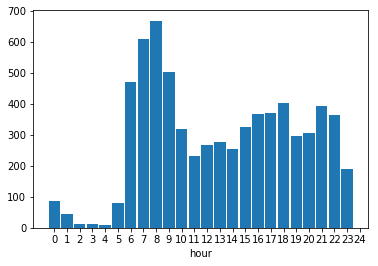

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.hist(hours, rwidth=0.9, bins = np.arange(-.5,24.5,1))
plt.xlabel('hour')
plt.xticks(np.arange(0,25,1));

9.Which hour does he tweet at most often? How many tweets did he have at 3 am?

In [35]:
from collections import Counter
freq = Counter(hours)
print(freq.most_common)

<bound method Counter.most_common of Counter({8: 669, 7: 610, 9: 502, 6: 470, 18: 402, 21: 392, 17: 371, 16: 367, 22: 363, 15: 326, 10: 320, 20: 305, 19: 298, 13: 278, 12: 269, 14: 255, 11: 233, 23: 191, 0: 85, 5: 81, 1: 45, 2: 13, 3: 12, 4: 8})>


10.We can also plot the days of the week that he tweets:

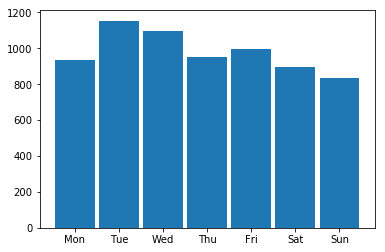

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

days = [date.weekday() for date in eastern_dates]

plt.hist(days, rwidth=0.9, bins = np.arange(-.5,7.5,1))
plt.xticks(np.arange(0,7,1),['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);

11.Next, we'll want to make a scatterplot of date versus number of tweets. This will take a couple of steps. First, create a dictionary called count_days such that the key is the date (just the month-day-year - not the hour or other stuff) and the value is the number of tweets on that date.

In [24]:
dates = [date.date() for date in eastern_dates]

count_days={}
for day in dates:
    if day not in count_days:
        count_days[day]=1
    else:
        count_days[day]+=1

12.Next, plot this dictionary using a histogram. Hint: google "python plot dictionary histogram" in order to do this.

Put the line "plt.rcParams['figure.figsize'] = [10, 5]" BEFORE you plot the histogram in order to see the dates along the x-axis clearly.

<Container object of 815 artists>

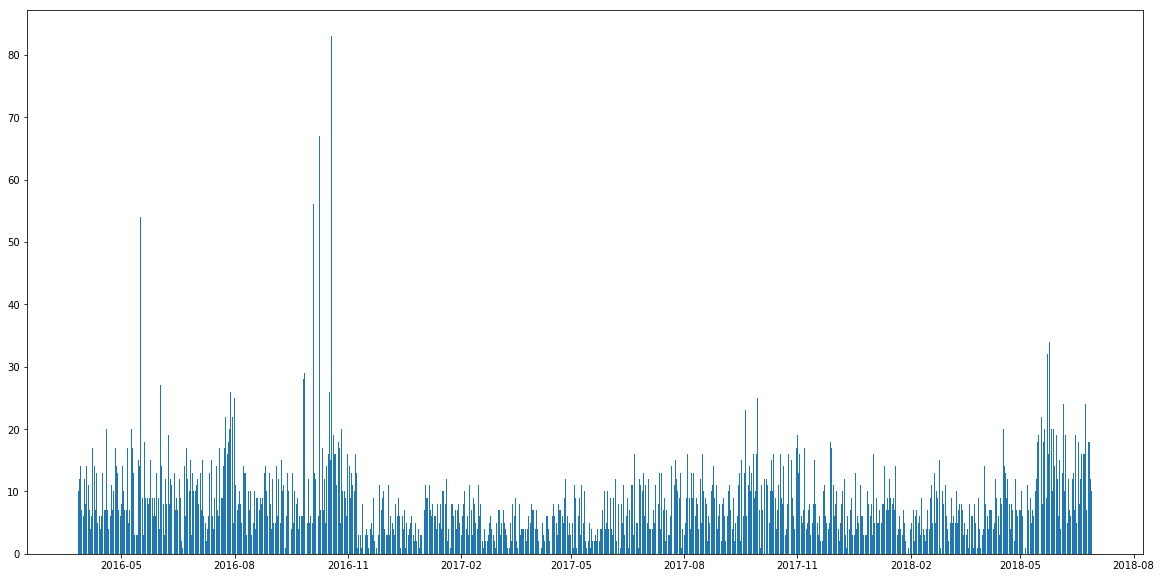

In [26]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.bar(list(count_days.keys()), count_days.values())

13.On which date did he tweet the most and how many tweets did he tweet?

In [25]:
from collections import Counter
freq = Counter(dates)
print(freq.most_common(1))

[(datetime.date(2016, 10, 19), 83)]


14.What were the maximum amount of retweets for one of his tweets and what was the tweet?

In [28]:
print(max(retweets))
print(text[retweets.index(max(retweets))])

369110
#FraudNewsCNN #FNN https://t.co/WYUnHjjUjg


### Chatbot

16.Now let's make a Donald Trump chatbot that uses his previous tweets to create new tweets. Let's make one long string that contains all of his tweets in lowercase format:

In [26]:
all_tweets = ''
for tweet in text:
    all_tweets = all_tweets + tweet
    
all_tweets = all_tweets.lower()

print(all_tweets[0:500])

rt @mitchellvii: trump always ends up being right.  it's almost a little freaky.rt @mitchellvii: exactly as i said - house intel chair: we cannot rule out sr. obama officials were involved in trump surveillance https://…big day for healthcare. working hard!today on #nationalagday, we honor our great american farmers &amp; ranchers. their hard work &amp; dedication are ingrained… https://t.co/ipgrhly2zjhonored to sign s.442 today. with this legislation, we support @nasa's scientists, engineers, a


17.Next, we'll remove certain punctuation (and hashtags and hyperlinks) and put spaces between other punctuation. We can do that most easily using regular expressions. The regular expression package is very powerful - there are loads of online tutorials for using regular expressions to manipulate strings.

In [27]:
import re


all_tweets = re.sub(r"http\S+", "", all_tweets) #remove hyperlinks
all_tweets = re.sub(r"amp\S+", "", all_tweets) #remove ampersand symbol
all_tweets = re.sub(r"\t", "", all_tweets)  # remove tabs
all_tweets = re.sub(r"\v", "", all_tweets)  # remove vertical space
all_tweets = re.sub(r"\r", "", all_tweets)  # remove carriage return
all_tweets = re.sub(r"\n", "", all_tweets)  # remove new lines
all_tweets = re.sub(r"\(", "", all_tweets)  # remove parenthesis
all_tweets = re.sub(r"\)", "", all_tweets)  # remove parenthesis
all_tweets = re.sub(r"\.\.\.", "", all_tweets)  # remove ...
all_tweets = re.sub(r"\. \. \. ", "", all_tweets)  # remove . . .
all_tweets = re.sub(r"\"", "", all_tweets)  # remove quotations
all_tweets = re.sub(r"!", "! ", all_tweets)  # insert space after !
all_tweets = re.sub(r"\.", ". ", all_tweets)  # insert space after .
all_tweets = re.sub(r"\?", "? ", all_tweets)  # insert space after ?

18.Split the string all_tweets into a list of words called words. Remove words that contain just punctuation in the following list:

In [28]:
words = all_tweets.split()
bad_words = ['…', '.', '!', '?', ',']
words = [x for x in words if x not in bad_words]

19.We'll make the chatbot using Markov chains. A Markov chain is a randomly determined model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. What does this mean?

We'll make a key-value dictionary where each key is a two word phrase and each value is a list containing all the possible single words that come after that phrase. Here's a concrete example. Read it carefully, paying special attention to the "and i" phrase.


"hi my name is Al and i live in a box that i like very much and i can live in there as long as i want"

"hi my" -> ["name"]

"my name" -> ["is"]

"name is" -> ["Al"]

"is Al" -> ["and"]

"Al and" -> ["i"]

"and i" -> ["live"]

........

"and i" -> ["live", "can"]

........

"i can" -> ["live"]

......

Here's the word_dict containing these key-value pairs:

In [40]:
word_dict=dict()
num_of_words = 2  # create phrases of length 2

for i in range(len(words)-num_of_words):
    phrase = ' '.join([words[j] for j in range(i, i+num_of_words)])
    if phrase not in word_dict:
        word_dict[phrase]=[words[i+num_of_words]]
    else:
        word_dict[phrase] = word_dict[phrase]+[words[i+num_of_words]]
        
print(word_dict['the fake'])

['news,', 'news', 'news', 'news', 'news', 'news', 'media', 'media', 'media', 'news', 'media.', 'media', 'news', 'news', 'media', 'media', 'trump/russia', 'news', 'news', 'news', '&', 'news', 'news,', 'news', 'news', 'news', 'msm', 'news.', 'news', 'news', 'news!', 'news', 'news', 'media,', '&', 'news', 'washington', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'newsif', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news', 'news,', 'news!', 'news', 'news,', 'news', 'news', 'news', 'news', 'news']


Here are the randomly generated tweets:

In [36]:
import random
#pick a random key value to start with
starting_phrase = random.choice(list(word_dict.keys()))
next_word = random.choice(word_dict[starting_phrase])
new_tweet = ' '.join([starting_phrase, next_word])

starting_phrase = starting_phrase.split()[1] + ' ' + next_word

while len(new_tweet) <= 140: #get approximately 140 characters
    try:
        next_word = random.choice(word_dict[starting_phrase])
        new_tweet = ' '.join([new_tweet, next_word])
        starting_phrase = starting_phrase.split()[1] + ' ' + next_word
    except:
        if new_tweet[-1] not in string.punctuation: #if we run out of pairs but it isn't the end of a line, make it the end of a sentence.
            new_tweet = ''.join([new_tweet, '.'])
            starting_phrase = random.choice(list(word_dict.keys())) #generate a new phrase to start a new sentence
            new_tweet = ' '.join([new_tweet, starting_phrase.capitalize()])
print(new_tweet.capitalize())

Mike tyson was not aware that russia is at it again. he is a nation that believes in the air! i am considering a veto of the economy! i will be


### Example 3: Movie Analysis
Using Selenium for automation

Let's read in some movie urls and movie data on the top 100 grossing movies of 2017.

In [30]:
movie_urls = []
with open('movieurls.txt', 'r') as f:
    for line in f:
        movie_urls.append(line.strip())
print(movie_urls[0:10])

movies = pd.read_pickle('movies.pkl')

['http://www.boxofficemojo.com/movies/?id=jurassicworldsequel.htm', 'http://www.boxofficemojo.com/movies/?id=starwars8.htm', 'http://www.boxofficemojo.com/movies/?id=beautyandthebeast2017.htm', 'http://www.boxofficemojo.com/movies/?id=wonderwoman.htm', 'http://www.boxofficemojo.com/movies/?id=jumanji2016.htm', 'http://www.boxofficemojo.com/movies/?id=marvel17a.htm', 'http://www.boxofficemojo.com/movies/?id=spiderman2017.htm', 'http://www.boxofficemojo.com/movies/?id=it.htm', 'http://www.boxofficemojo.com/movies/?id=marvel2017.htm', 'http://www.boxofficemojo.com/movies/?id=despicableme3.htm']


Let's go to each movie url and save the director's name. We'll need Selenium to go to each website for us, find the director, and save it. Let's import the necessary packages first.

If you have Anaconda installed already, try typing into your terminal: 

conda install -c conda-forge selenium

Then download the latest version of chromedriver directly from:

https://sites.google.com/a/chromium.org/chromedriver/downloads

2.Unzip it and move it into your APPLICATIONS folder if you have a Mac or your Desktop if you have a PC.

3.IF YOU HAVE A MAC: replace "chromedriver = '/usr/local/bin/chromedriver'" with "chromedriver = '/Applications/chromedriver'" in the cell below.

IF YOU HAVE WINDOWS: You will need double backslashes. Replace "chromedriver = '/usr/local/bin/chromedriver'" with something like chromedriver = "C:\\\Users\\\{Your_user_name}\\\Desktop\\\chromedriver" below. (Example: chromedriver = "C:\\\Users\\\shareshian\\\Desktop\\\chromedriver")

In [42]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
chromedriver = "/usr/local/bin/chromedriver"

for i in range(5):
    chromedriver = "/usr/local/bin/chromedriver"
    driver = webdriver.Chrome(chromedriver)
    url = movie_urls[i]
    driver.get(url)
    href = driver.find_element_by_xpath( '//a[contains(@href, "/people/chart/?view=Director")]')
    director = href.text
    print(director)
    driver.close()

J.A. Bayona
Rian Johnson
Bill Condon
Patty Jenkins
Jake Kasdan


Using this technique, we could find that only Ridley Scott has more than one of the top 100 grossing movies in 2017:

In [32]:
movies[movies['director']=='Ridley Scott']

,movie,total gross,open gross,open date,ratio,open month,director
41,Alien: Covenant,74262031,36160621,2017-05-19,0.486933,5,Ridley Scott
91,All the Money in the World,25113707,5584684,2017-12-25,0.222376,12,Ridley Scott


Note: Beautiful Soup is another important webscraping packages. You can find tutorials online.

Best Resoures for Learning Python:
- Grok learning Python Beginner and Intermediate courses - https://groklearning.com/  (great for students)
- Think Stats 2e & Think Python 2e, Allen B. Downey
http://greenteapress.com/wp/think-stats-2e/
- Python For Everyone, Charles Severance:
https://www.py4e.com/html3/

- UCSD Extension Courses: Python for Informatics, Python Programming Fundamentals, Advanced Python Programming (coming soon)
https://extension.ucsd.edu/courses-and-programs/python-for-informatics

https://extension.ucsd.edu/courses-and-programs/python-programming-fundamentals
- UC Berkeley Data Science course materials:
http://www.data8.org

- CodeCademy & Coursera

- My course materials:

https://github.com/laurenshareshian/Python_For_Math_Teachers

https://github.com/laurenshareshian/Python_Course_Lessons
